In [1]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [2]:
from pyspark.sql.functions import udf
import string
import re
from pyspark.ml.feature import Tokenizer,StopWordsRemover
from pyspark.ml import Pipeline, PipelineModel

In [3]:
#read in files from mongodb
review_raw =spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri","mongodb://ec2-54-202-247-153.us-west-2.compute.amazonaws.com/project.review").load()
biz_raw =spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri","mongodb://ec2-54-202-247-153.us-west-2.compute.amazonaws.com/project.business").load()

In [4]:
#remove 3 stars reviews so that revies are polarized
review = review_raw.select('text','stars')
review_neg = review.filter("stars<3").select("text")
review_pos = review.filter("stars>=4").select("text")

In [5]:
def remove_num_punct(text):
    text = text.lower()
    my_string = text.replace("-", " ")
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", my_string)  # delete stuff but leave at least a space to avoid clumping together
    return nopunct

udf_num_punct = udf(lambda x:remove_num_punct(x))

In [6]:
def bi_gram(words):
    words = [w for w in words if len(w) > 0]
    bigram = [" ".join([words[i],words[i+1]])for i in range(len(words)-1)]
    return bigram

In [7]:
def tri_gram(words):
    words = [w for w in words if len(w) > 0]
    trigram = [" ".join([words[i],words[i+1],words[i+2]])for i in range(len(words)-2)]
    return trigram

In [8]:
#tokenizer and stopwordsremover pipeline
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered", caseSensitive=False)
pipeline=Pipeline(stages=[tokenizer,remover])

## Top 15 N-gram from Positive Reviews

In [9]:
review_pos = review_pos.select(udf_num_punct('text').alias('text'))
pos_words=pipeline.fit(review_pos).transform(review_pos).select("filtered")
pos_rdd= pos_words.rdd.map(list).map(lambda x:x[0]).cache()

In [10]:
#Unigram
pos_uni=pos_rdd.flatMap(lambda words: [w for w in words if len(w) > 0])
top_pos_uni = pos_uni.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
#Bigram
pos_bi= pos_rdd.flatMap(lambda x: bi_gram(x))
top_pos_bi = pos_bi.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
#Trigram
pos_tri= pos_rdd.flatMap(lambda x: tri_gram(x))
top_pos_tri = pos_tri.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)

print top_pos_uni.collect()[0:15]
print top_pos_bi.collect()[0:15]
print top_pos_tri.collect()[0:15]

[(u'great', 86578), (u'good', 77265), (u'place', 77074), (u'food', 70852), (u'service', 49974), (u'time', 49317), (u'like', 48397), (u'one', 45553), (u'get', 44504), (u'go', 39815), (u'back', 39669), (u'really', 39629), (u'also', 36377), (u'best', 34526), (u've', 32856)]
[(u'highly recommend', 7782), (u'first time', 6767), (u'customer service', 5738), (u'really good', 5726), (u'go back', 5637), (u'come back', 5269), (u'great service', 4929), (u'great place', 4776), (u'las vegas', 4704), (u'ice cream', 4485), (u'love place', 4461), (u'next time', 4387), (u've ever', 4324), (u'great food', 4256), (u'make sure', 3864)]
[(u'definitely come back', 1224), (u'great customer service', 1176), (u'wait go back', 1104), (u'definitely go back', 1066), (u'highly recommend place', 835), (u'definitely coming back', 825), (u'food great service', 795), (u'best ve ever', 757), (u'mac n cheese', 701), (u'great food great', 694), (u'next time m', 618), (u'love love love', 615), (u'sweet potato fries', 587)

## Top 15 N-gram from Negative Review

In [11]:
review_neg = review_neg.select(udf_num_punct('text').alias('text'))
neg_words=pipeline.fit(review_neg).transform(review_neg).select("filtered")
neg_rdd= neg_words.rdd.map(list).map(lambda x:x[0]).cache()

In [12]:
#Unigram
neg_uni=neg_rdd.flatMap(lambda words: [w for w in words if len(w) > 0])
top_neg_uni = neg_uni.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
#Bigram
neg_bi= neg_rdd.flatMap(lambda x: bi_gram(x))
top_neg_bi = neg_bi.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)
#Trigram
neg_tri= neg_rdd.flatMap(lambda x: tri_gram(x))
top_neg_tri = neg_tri.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)

print top_neg_uni.collect()[0:15]
print top_neg_bi.collect()[0:15]
print top_neg_tri.collect()[0:15]

[(u'food', 31803), (u'place', 26586), (u'like', 25106), (u'get', 25003), (u'service', 24726), (u'one', 24717), (u'time', 23433), (u'back', 22966), (u'good', 20908), (u'us', 19177), (u'go', 18471), (u'even', 17505), (u'never', 15664), (u'said', 15285), (u'didn', 15021)]
[(u'customer service', 5289), (u'go back', 2937), (u'come back', 2217), (u'first time', 2202), (u'even though', 1858), (u'tasted like', 1572), (u'didn even', 1539), (u'going back', 1475), (u'came back', 1400), (u'front desk', 1385), (u'last time', 1270), (u've ever', 1206), (u'never go', 1197), (u'much better', 1196), (u'told us', 1180)]
[(u'never go back', 776), (u'go somewhere else', 418), (u'worst customer service', 338), (u'horrible customer service', 319), (u'poor customer service', 314), (u'never come back', 300), (u'won going back', 292), (u'waste time money', 279), (u'never going back', 264), (u'worst service ever', 229), (u'terrible customer service', 228), (u'long story short', 216), (u'took minutes get', 206),

## Wordcloud for Single Business

In [13]:
# select the restaurants with the most number of reviews, seems that they are all from LV - high class buffet
biz_raw.sort('review_count',ascending = False).select('name','review_count','city').show(truncate=False)

+--------------------------------+------------+---------+
|name                            |review_count|city     |
+--------------------------------+------------+---------+
|Mon Ami Gabi                    |6979        |Las Vegas|
|Bacchanal Buffet                |6417        |Las Vegas|
|Wicked Spoon                    |5632        |Las Vegas|
|Gordon Ramsay BurGR             |5429        |Las Vegas|
|Earl of Sandwich                |4789        |Las Vegas|
|Hash House A Go Go              |4371        |Las Vegas|
|Serendipity 3                   |3913        |Las Vegas|
|The Buffet                      |3873        |Las Vegas|
|Lotus of Siam                   |3838        |Las Vegas|
|The Buffet at Bellagio          |3700        |Las Vegas|
|ARIA Resort & Casino            |3634        |Las Vegas|
|The Cosmopolitan of Las Vegas   |3621        |Las Vegas|
|Secret Pizza                    |3542        |Las Vegas|
|Bouchon at the Venezia Tower    |3439        |Las Vegas|
|Luxor Hotel a

In [14]:
# select a business, 'Wicked Spoon', and look for its business_id
biz_raw.filter("name like '%Wicked Spoon%'").select('business_id').show(truncate=False)

+----------------------+
|business_id           |
+----------------------+
|K7lWdNUhCbcnEvI0NhGewg|
+----------------------+



In [15]:
# filter out the reviews of this restaurant
biz = review_raw.filter("business_id like '%K7lWdNUhCbcnEvI0NhGewg%'").select("text")

In [16]:
review_biz = biz.select(udf_num_punct('text').alias('text'))
biz_words=pipeline.fit(review_biz).transform(review_biz).select("filtered")
words_rdd= biz_words.rdd.map(list).map(lambda x:x[0]).map(lambda words: [w for w in words if len(w) > 0]).cache()

In [17]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
def tok(words):
    goodwords = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return goodwords

In [18]:
def bi_gram2(words):
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    bigram = [" ".join([words[i],words[i+1]])for i in range(len(words)-1)]
    return bigram

In [19]:
def tri_gram2(words):
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    trigram = [" ".join([words[i],words[i+1],words[i+2]])for i in range(len(words)-2)]
    return trigram

In [20]:
biz_uni = words_rdd.flatMap(lambda x : tok(x)).collect()
biz_list_bi = words_rdd.flatMap(lambda x: bi_gram2(x)).collect()
biz_list_tri = words_rdd.flatMap(lambda x: tri_gram2(x)).collect()

In [21]:
from collections import Counter
ctr1 = Counter(biz_uni)
ctr2 = Counter(biz_list_bi)
ctr3 = Counter(biz_list_tri)

In [22]:
#can edit
ctrall = ctr2.most_common(100)+ctr3.most_common(100)

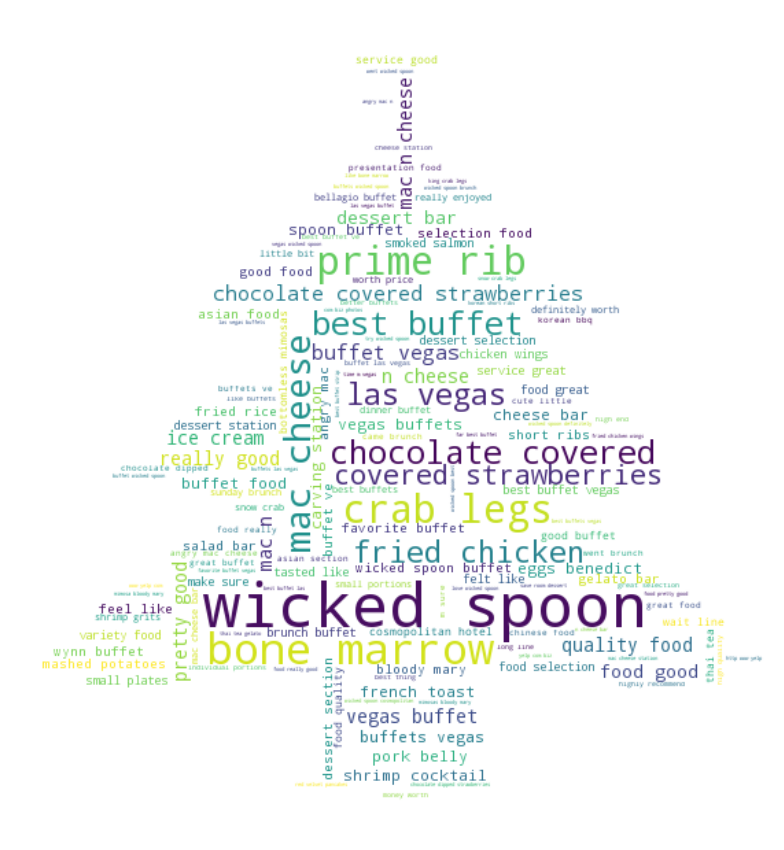

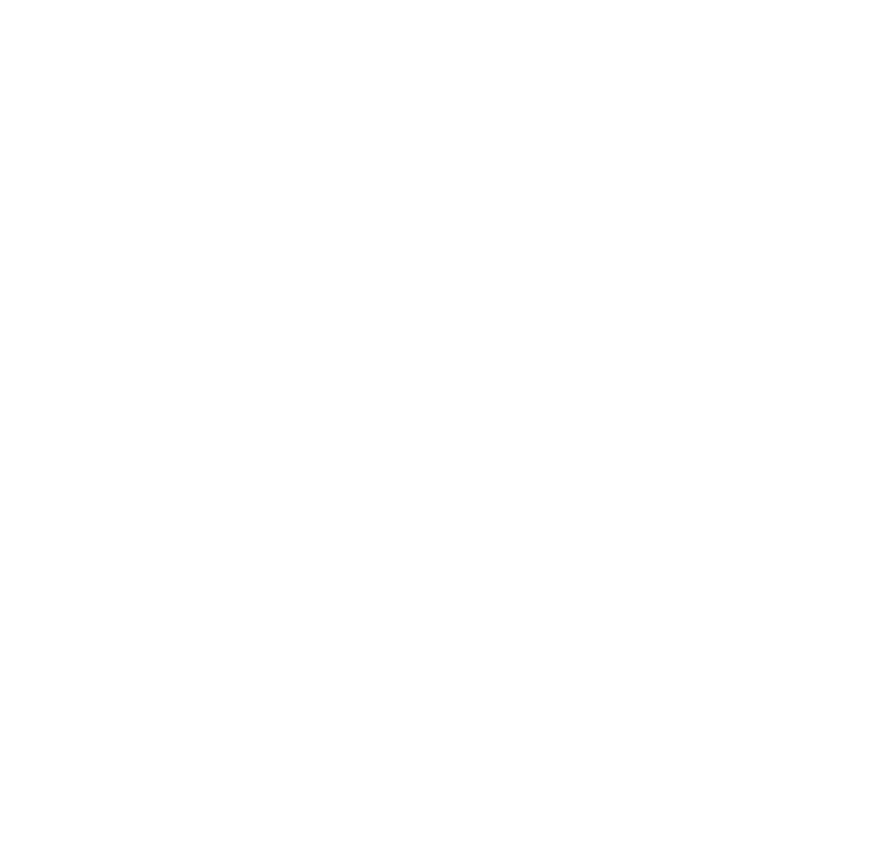

In [25]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

alice_mask = np.array(Image.open("tree5.png"))

wc = WordCloud(background_color="white",width=2000, height=1000,  max_words=500, mask=alice_mask)
wc.fit_words(dict(ctrall))

# store to file
wc.to_file("alice.png")

# show
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.show()